In [0]:
from tweepy import OAuthHandler
from tweepy import API

# Consumer key authentication
auth = OAuthHandler(consumer_key, consumer_secret)

# Access key authentication
auth.set_access_token(access_token, access_token_secret)

# Set up the API with the authentication handler
api = API(auth)

In [0]:
from tweepy.streaming import StreamListener
import json
import time
import sys

class SListener(StreamListener):
    def __init__(self, api = None, fprefix = 'streamer'):
        self.api = api or API()
        self.counter = 0
        self.fprefix = fprefix
        self.output  = open('tweets.json', 'w')


    def on_data(self, data):
        if  'in_reply_to_status' in data:
            self.on_status(data)
        elif 'delete' in data:
            delete = json.loads(data)['delete']['status']
            if self.on_delete(delete['id'], delete['user_id']) is False:
                return False
        elif 'limit' in data:
            if self.on_limit(json.loads(data)['limit']['track']) is False:
                return False
        elif 'warning' in data:
            warning = json.loads(data)['warnings']
            print("WARNING: %s" % warning['message'])
            return


    def on_status(self, status):
        self.output.write(status)
        self.counter += 1
        if self.counter >= 20000:
            self.output.close()
            self.output  = open('%s_%s.json' % (self.fprefix, time.strftime('%Y%m%d-%H%M%S')), 'w')
            self.counter = 0
        return


    def on_delete(self, status_id, user_id):
        print("Delete notice")
        return


    def on_limit(self, track):
        print("WARNING: Limitation notice received, tweets missed: %d" % track)
        return


    def on_error(self, status_code):
        print('Encountered error with status code:', status_code)
        return 


    def on_timeout(self):
        print("Timeout, sleeping for 60 seconds...")
        time.sleep(60)
        return 

In [179]:
from tweepy import Stream

# Set up words to track  
keywords_to_track = ['python','javascript']

# Instantiate the SListener object 
listen = SListener(api)

# Instantiate the Stream object
stream = Stream(auth, listen)

# Begin collecting data
stream.filter(track = keywords_to_track)

ProtocolError: ignored

In [0]:
import glob
import pandas as pd
import numpy as np

In [0]:
tweets = []
files  = list(glob.iglob('/content/tweets.json'))
for f in files:
    fh = open(f, 'r', encoding = 'utf-8')
    tweets_json = fh.read().split("\n")

    ## remove empty lines
    tweets_json = list(filter(len, tweets_json))

    ## parse each tweet
    for tweet in tweets_json:
        tweet_obj = json.loads(tweet)
    
        # Store the user screen name in 'user-screen_name'
        tweet_obj['user-screen_name'] = tweet_obj['user']['screen_name']
    
        # Check if this is a 140+ character tweet
        if 'extended_tweet' in tweet_obj:
            # Store the extended tweet text in 'extended_tweet-full_text'
            tweet_obj['extended_tweet-full_text'] = tweet_obj['extended_tweet']['full_text']
    
        if 'retweeted_status' in tweet_obj:
            # Store the retweet user screen name in 'retweeted_status-user-screen_name'
            tweet_obj['retweeted_status-user-screen_name'] = tweet_obj['retweeted_status']['user']['screen_name']

            # Store the retweet text in 'retweeted_status-text'
            tweet_obj['retweeted_status-text'] = tweet_obj['retweeted_status']['text']

        if 'quoted_status' in tweet_obj:
            # Store the retweet user screen name in 'retweeted_status-user-screen_name'
            tweet_obj['quoted_status-user-screen_name'] = tweet_obj['quoted_status']['user']['screen_name']

            # Store the retweet text in 'retweeted_status-text'
            tweet_obj['quoted_status-text'] = tweet_obj['quoted_status']['text']
            
        tweets.append(tweet_obj)


In [0]:
## create pandas DataFrame for further analysis
df_tweet = pd.DataFrame(tweets)

In [184]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   created_at                         146 non-null    object 
 1   id                                 146 non-null    int64  
 2   id_str                             146 non-null    object 
 3   text                               146 non-null    object 
 4   source                             146 non-null    object 
 5   truncated                          146 non-null    bool   
 6   in_reply_to_status_id              8 non-null      float64
 7   in_reply_to_status_id_str          8 non-null      object 
 8   in_reply_to_user_id                9 non-null      float64
 9   in_reply_to_user_id_str            9 non-null      object 
 10  in_reply_to_screen_name            9 non-null      object 
 11  user                               146 non-null    object 

In [0]:
def check_word_in_tweet(word, data):
    """Checks if a word is in a Twitter dataset's text. 
    Checks text and extended tweet (140+ character tweets) for tweets,
    retweets and quoted tweets.
    Returns a logical pandas Series.
    """
    contains_column = data['text'].str.contains(word, case = False)
    contains_column |= data['extended_tweet-full_text'].str.contains(word, case = False)
    contains_column |= data['quoted_status-text'].str.contains(word, case = False) 
    contains_column |= data['retweeted_status-text'].str.contains(word, case = False) 
    return contains_column

In [186]:
# Find mentions of #python in all text fields
python = check_word_in_tweet('python', df_tweet)
# Find mentions of #javascript in all text fields
js = check_word_in_tweet('javascript', df_tweet)

# Print proportion of tweets mentioning #python
print("Proportion of #python tweets:", np.sum(python) / df_tweet.shape[0])

# Print proportion of tweets mentioning #rstats
print("Proportion of #javascript tweets:", np.sum(js) / df_tweet.shape[0])

Proportion of #python tweets: 0.4589041095890411
Proportion of #javascript tweets: 0.3972602739726027


In [187]:
# Print created_at to see the original format of datetime in Twitter data
print(df_tweet['created_at'].head())

# Convert the created_at column to np.datetime object
df_tweet['created_at'] = pd.to_datetime(df_tweet['created_at'])

# Print created_at to see new format
print(df_tweet['created_at'].head())

# Set the index of ds_tweets to created_at
df_tweet = df_tweet.set_index('created_at')

0    Thu May 28 20:40:07 +0000 2020
1    Thu May 28 20:40:08 +0000 2020
2    Thu May 28 20:40:11 +0000 2020
3    Thu May 28 20:40:13 +0000 2020
4    Thu May 28 20:40:14 +0000 2020
Name: created_at, dtype: object
0   2020-05-28 20:40:07+00:00
1   2020-05-28 20:40:08+00:00
2   2020-05-28 20:40:11+00:00
3   2020-05-28 20:40:13+00:00
4   2020-05-28 20:40:14+00:00
Name: created_at, dtype: datetime64[ns, UTC]


In [0]:
# Create a python column
df_tweet['python'] = check_word_in_tweet('python', df_tweet)

# Create an js column
df_tweet['js'] = check_word_in_tweet('javascript', df_tweet)

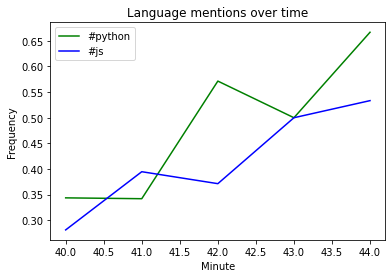

In [189]:
import matplotlib.pyplot as plt
# Average of python column by day
mean_python = df_tweet['python'].resample('1 min').mean()

# Average of rstats column by day
mean_js = df_tweet['js'].resample('1 min').mean()

# Plot mean python/rstats by day
plt.plot(mean_python.index.minute, mean_python, color = 'green')
plt.plot(mean_js.index.minute, mean_js, color = 'blue')

# Add labels and show
plt.xlabel('Minute'); plt.ylabel('Frequency')
plt.title('Language mentions over time')
plt.legend(('#python', '#js'))
plt.show()

In [199]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146 entries, 2020-05-28 20:40:07+00:00 to 2020-05-28 20:44:10+00:00
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 146 non-null    int64  
 1   id_str                             146 non-null    object 
 2   text                               146 non-null    object 
 3   source                             146 non-null    object 
 4   truncated                          146 non-null    bool   
 5   in_reply_to_status_id              8 non-null      float64
 6   in_reply_to_status_id_str          8 non-null      object 
 7   in_reply_to_user_id                9 non-null      float64
 8   in_reply_to_user_id_str            9 non-null      object 
 9   in_reply_to_screen_name            9 non-null      object 
 10  user                               146 non-null    object 
 11  geo      

In [200]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [0]:
# Load SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Generate sentiment scores
sentiment_scores = df_tweet['text'].apply(sid.polarity_scores)

In [0]:
sentiment = sentiment_scores.apply(lambda x: x['compound'])


In [203]:
# Print out the text of a positive tweet
print(df_tweet[sentiment > 0.6]['text'].values[0])

# Print out the text of a negative tweet
print(df_tweet[sentiment < -0.6]['text'].values[0])

# Generate average sentiment scores for #python
sentiment_py = sentiment[ check_word_in_tweet('#python', df_tweet) ].resample('1 min').mean()

# Generate average sentiment scores for #rstats
sentiment_js = sentiment[ check_word_in_tweet('#javascript', df_tweet) ].resample('1 min').mean()

RT @_marcba: If you like Python, code Python.
If you like JavaScript, code JavaScript.
If you like Node, code Node.
If you like Deno, code…


IndexError: ignored

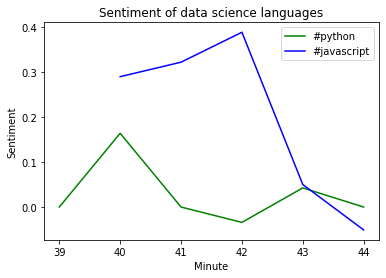

In [205]:
# Import matplotlib
import matplotlib.pyplot as plt

# Plot average #python sentiment per day
plt.plot(sentiment_py.index.minute, sentiment_py, color = 'green')

# Plot average #rstats sentiment per day
plt.plot(sentiment_js.index.minute, sentiment_js, color = 'blue')

plt.xlabel('Minute')
plt.ylabel('Sentiment')
plt.title('Sentiment of data science languages')
plt.legend(('#python', '#javascript'))
plt.show()